In [1]:
import os
from tqdm import tqdm

from torch.utils.data import DataLoader

from dataset import MAEHeartDataset

/home/ymelkani/.conda/envs/heart-analysis/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
vid_path = '../../../../../../project/Drosophila_MelkaniLab/YASH/Videos/Control/Control_1wf_02_C11440_30s2.avi'

dataset = MAEHeartDataset(vid_path, n_frames=500, balance=True, augment=True, seed=0)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=4)


In [3]:
for _ in tqdm(range(100)):
    for batch in dataloader:
        continue

100%|██████████| 100/100 [01:41<00:00,  1.01s/it]


# Multi-threading for gathering pretraining dataset


In [1]:
import concurrent.futures
import glob
import os
import time

from dataset import MAEHeartDataset

/home/ymelkani/.conda/envs/heart-analysis/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:
base_dir = '../../../../../../../data/project/Drosophila_MelkaniLab/'
dirs = ['YASH/YASH/Misc/AHA Obesity/']
n_frames= 500

t0 = time.time()
datasets = []
for d in dirs:
    for vid_path in glob.glob(os.path.join(base_dir, d, '**/*.avi'), recursive = True):

        if os.path.getsize(vid_path) < 1e6: # ignore corrupted videos
            continue
        if 'GM_Uploaded' in vid_path and 'Laminopathy Project' not in vid_path: # do not include the videos used for segmentation model evaluation (laminopathy study vids are fine)
            continue
        datasets.append(MAEHeartDataset(vid_path, n_frames=n_frames, balance=True, augment=True, seed=0))
print(f"loaded {len(datasets)} datasets in {time.time() - t0}s")
        

loaded 94 datasets in 77.36628937721252s


In [5]:
def create_dataset(vid_path, n_frames):
    return MAEHeartDataset(vid_path, n_frames=n_frames, balance=True, augment=True, seed=0)

def create_datasets_concurrently(file_paths, n):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        # Use map to maintain the order of results
        results = executor.map(create_dataset, file_paths, [n] * len(file_paths))
        
    return list(results)


t0 = time.time()
datasets = []
for d in dirs:
    for vid_path in glob.glob(os.path.join(base_dir, d, '**/*.avi'), recursive = True):

        if os.path.getsize(vid_path) < 1e5: # ignore corrupted videos
            continue
        if 'GM_Uploaded' in vid_path and 'Laminopathy Project' not in vid_path: # do not include the videos used for segmentation model evaluation (laminopathy study vids are fine)
            continue
        datasets.append(vid_path)
        
datasets = create_datasets_concurrently(datasets, 500)
        
print(f"loaded {len(datasets)} datasets in {time.time() - t0}s")


loaded 94 datasets in 13.746831178665161s


# Find Pretraining Videos

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

import glob
import os

In [7]:
base_path = '../../../../../../../data/project/Drosophila_MelkaniLab/'
dirs = ['YASH/YASH/Misc/AHA Obesity/',
        'YASH/Videos/',
        'GIRISH/ALF & TRF 5 WEEK SCIENCE 2015/',
        'GIRISH/Dilated Cardiomyopathy Model/',
        'SHARED_VIDEOS/machine_learning/GM_Uploaded/']

vids = []

for d in dirs:
    new_vids = glob.glob(os.path.join(base_path, d, '**/*.avi'), recursive = True)
    print(d, len(new_vids))
    vids = vids + new_vids

YASH/YASH/Misc/AHA Obesity/ 94
YASH/Videos/ 170
GIRISH/ALF & TRF 5 WEEK SCIENCE 2015/ 120
GIRISH/Dilated Cardiomyopathy Model/ 65
SHARED_VIDEOS/machine_learning/GM_Uploaded/ 422


../../../../../../../data/project/Drosophila_MelkaniLab/YASH/Videos/Publishing/CS/Hand+_04_3WM_30s.avi


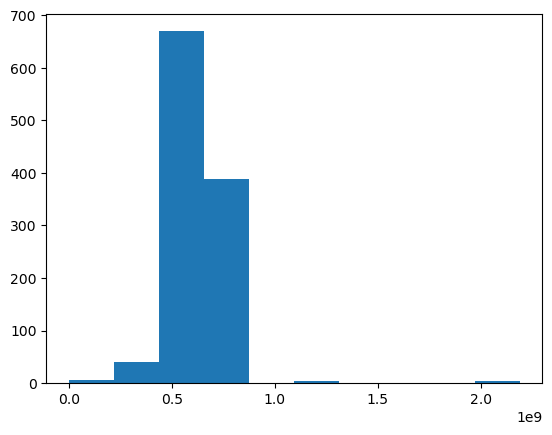

In [21]:
sizes = []
for path in vids:
    sizes.append(os.path.getsize(path))

sizes = np.array(sizes)
print(vids[sizes.argmax()])
    
plt.hist(sizes)
plt.show()

In [25]:
for v in vids:
    if os.path.getsize(v) == 5686:
        print(v)

../../../../../../../data/project/Drosophila_MelkaniLab/SHARED_VIDEOS/machine_learning/CXD_Test/test1.avi
../../../../../../../data/project/Drosophila_MelkaniLab/SHARED_VIDEOS/machine_learning/CXD_Test/test2.avi


True


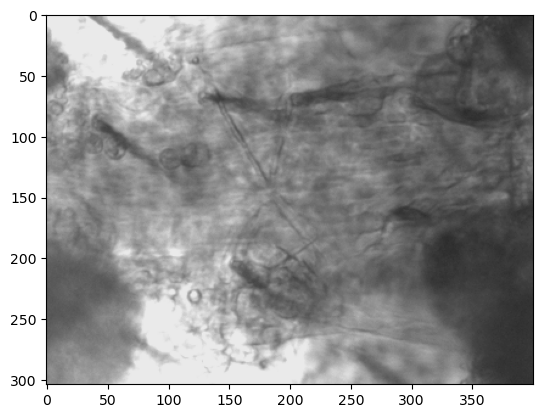

In [34]:
path = '../../../../../../../data/project/Drosophila_MelkaniLab/YASH/Videos/Publishing/CS/Hand+_04_3WM_30s.avi'
cap = cv2.VideoCapture(path)

ret, frame = cap.read()
print(ret)
plt.imshow(frame)

In [9]:
path = '../../../../../../../data/project/Drosophila_MelkaniLab/YASH/YASH/Misc/AHA Obesity/HBL 1623/HBL65004_2wm_3_C11440_30s3.avi'
cap = cv2.VideoCapture(path)

print(int(cap.get(cv2.CAP_PROP_POS_FRAMES)))

for i in range(200):
    ret, frame = cap.read()
    
print(int(cap.get(cv2.CAP_PROP_POS_FRAMES)))

for i in range(120):
    cap.read()
    
print(int(cap.get(cv2.CAP_PROP_POS_FRAMES)))

cap = cv2.VideoCapture(path)
print(int(cap.get(cv2.CAP_PROP_POS_FRAMES)))


0
200
320
0


### Final Pretraining Counts

In [24]:
base_path = '../../../../../../../data/project/Drosophila_MelkaniLab/'
dirs = ['YASH/YASH/Misc/AHA Obesity/',
        'YASH/Videos/',
        'GIRISH/ALF & TRF 5 WEEK SCIENCE 2015/',
        'GIRISH/Dilated Cardiomyopathy Model/',
        'SHARED_VIDEOS/machine_learning/']

lengths = []
vids = []

for d in dirs:
    cnt = 0
    for vid_path in glob.glob(os.path.join(base_path, d, '**/*.avi'), recursive = True):

        if os.path.getsize(vid_path) < 1e6: # ignore corrupted videos
            continue
        if 'GM_Uploaded' in vid_path and 'Laminopathy Project' not in vid_path: # do not include the videos used for segmentation model evaluation (laminopathy study vids are fine)
            continue
            
        cnt += 1
        vids.append(vid_path)
        cap = cv2.VideoCapture(vid_path)
        lengths.append(int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))
        
    print(d, cnt)

print('TOTAL:', len(vids))

YASH/YASH/Misc/AHA Obesity/ 94
YASH/Videos/ 168
GIRISH/ALF & TRF 5 WEEK SCIENCE 2015/ 120
GIRISH/Dilated Cardiomyopathy Model/ 65
SHARED_VIDEOS/machine_learning/ 393
TOTAL: 840


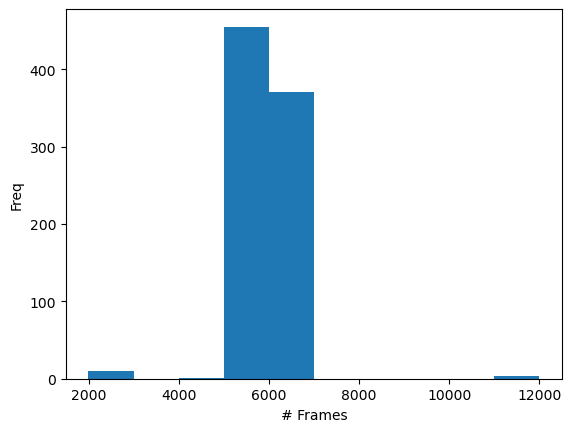

In [23]:
plt.hist(lengths)
plt.xlabel('# Frames')
plt.ylabel('Freq')
plt.show()

# Masking

In [18]:
import numpy as np
import matplotlib.pyplot as plt

import cv2

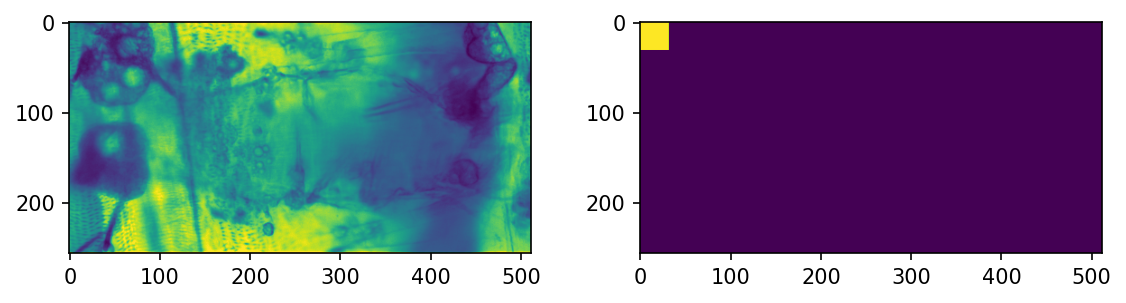

In [37]:
path = '../../../../../../project/Drosophila_MelkaniLab/YASH/Videos/Control/Control_1wf_02_C11440_30s2.avi'
target = 10
patch_size = (32, 32)

cap = cv2.VideoCapture(path)
cap.set(cv2.CAP_PROP_POS_FRAMES, target)
_, frame = cap.read()
frame = frame[:, :, 0:1]

h, w, c = frame.shape
ph, pw = patch_size
nh = h // ph
nw = w // pw

mask = np.zeros_like(frame, dtype=np.bool)

mask = mask.reshape(nh, ph, nw, pw, c) # (h, w, c) -> (nh, ph, nw, pw, c)
mask = np.transpose(mask, (1, 3, 0, 2, 4)) # -> (ph, pw, nh, nw, c)
mask = mask.reshape(ph, pw, nh*nw*c) # -> (ph, pw, nh*nw*c) 
mask[:, :, 0] = True
mask = mask.reshape(ph, pw, nh, nw, c) # (ph, pw, nh*nw*c) -> (ph, pw, nh, nw, c)
mask = np.transpose(mask, (2, 0, 3, 1, 4)) # -> (nh, ph, nw, pw, c)
mask = mask.reshape(h, w, c) # ->(h, w, c)

mask = mask.reshape(h, w, c)

fig, axs = plt.subplots(1, 2, figsize=(9, 2), dpi=150)

axs[0].imshow(frame)
axs[1].imshow(mask)

# Selecting dissimilar frames

Previously we selected frames at $t-4$, $t$, and, $t+4$ to construct our 3 channel input. But in some stages of contraction, 4 timesteps is not enough to provide additional info about beating pattern. For example in diastolic, all three frames may look the same. Can we reliably find 'dissimilar enough' frames so that the two outer frames are not the same as the middle frame?

In [46]:
import numpy as np
import matplotlib.pyplot as plt

import cv2
from tqdm import tqdm

100%|██████████| 500/500 [00:00<00:00, 718.81it/s]


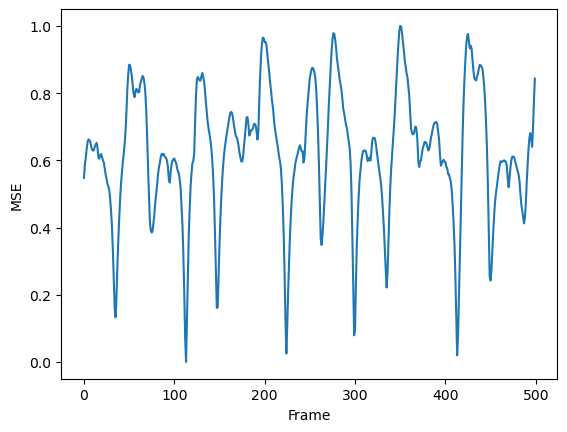

In [49]:
path = '../../../../../../project/Drosophila_MelkaniLab/YASH/Videos/Control/Control_1wf_03_C11440_30s3.avi'

cap = cv2.VideoCapture(path)
vid_len = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
cap.set(cv2.CAP_PROP_POS_FRAMES, vid_len-1)
_, ref = cap.read()
ref = ref[:, :, 0:1]

cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
diffs = []
for _ in tqdm(range(500)):
    _, img = cap.read()
    img = img[:, :, 0:1]
    diffs.append(((img - ref)**2).mean())
    
diffs = np.array(diffs)
diffs = (diffs - diffs.min()) / (diffs.max() - diffs.min())
    
plt.plot(diffs)
plt.xlabel("Frame")
plt.ylabel("MSE")
plt.show()

In [43]:
n_bins = 25

frame_group = []
group_frames = {}

for i in range(len(diffs)):
    
    group_id = int(diffs[i] * n_bins)
    frame_group.append(group_id)
    
    if group_id not in group_frames:
        group_frames[group_id] = []
    group_frames[group_id].append(i)
    

frame_neighbors = []

for f in range(len(diffs)):
       
    nf = (f + 4) % len(diffs)
    while True:
        if abs(frame_group[nf] - frame_group[f]) >= 8:
            break
        nf = (nf + 1) % len(diffs)
    
    pf = (f - 4) % len(diffs)

    while True:
        if abs(frame_group[pf] - frame_group[f]) >= 8:
            break
        pf = (pf - 1) % len(diffs)
    
    frame_neighbors.append((pf, nf))
    

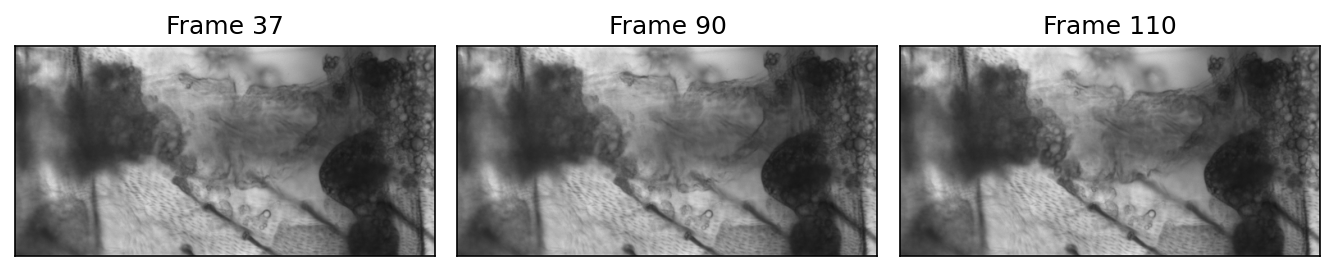

In [44]:
frame = 90
pf, nf = frame_neighbors[frame]

cap.set(cv2.CAP_PROP_POS_FRAMES, pf)
_, f1 = cap.read()
cap.set(cv2.CAP_PROP_POS_FRAMES, frame)
_, f2 = cap.read()
cap.set(cv2.CAP_PROP_POS_FRAMES, nf)
_, f3 = cap.read()

frames = [f1, f2, f3]
fns = [pf, frame, nf]

fig, axs = plt.subplots(1, 3, figsize=(9, 2), dpi=150)

for i in range(3):
    axs[i].imshow(frames[i])
    
    axs[i].set_title(f"Frame {fns[i]}")
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    
plt.tight_layout()
plt.show()

451 10 33
499 30 34
37 90 110
150 170 198
264 290 297


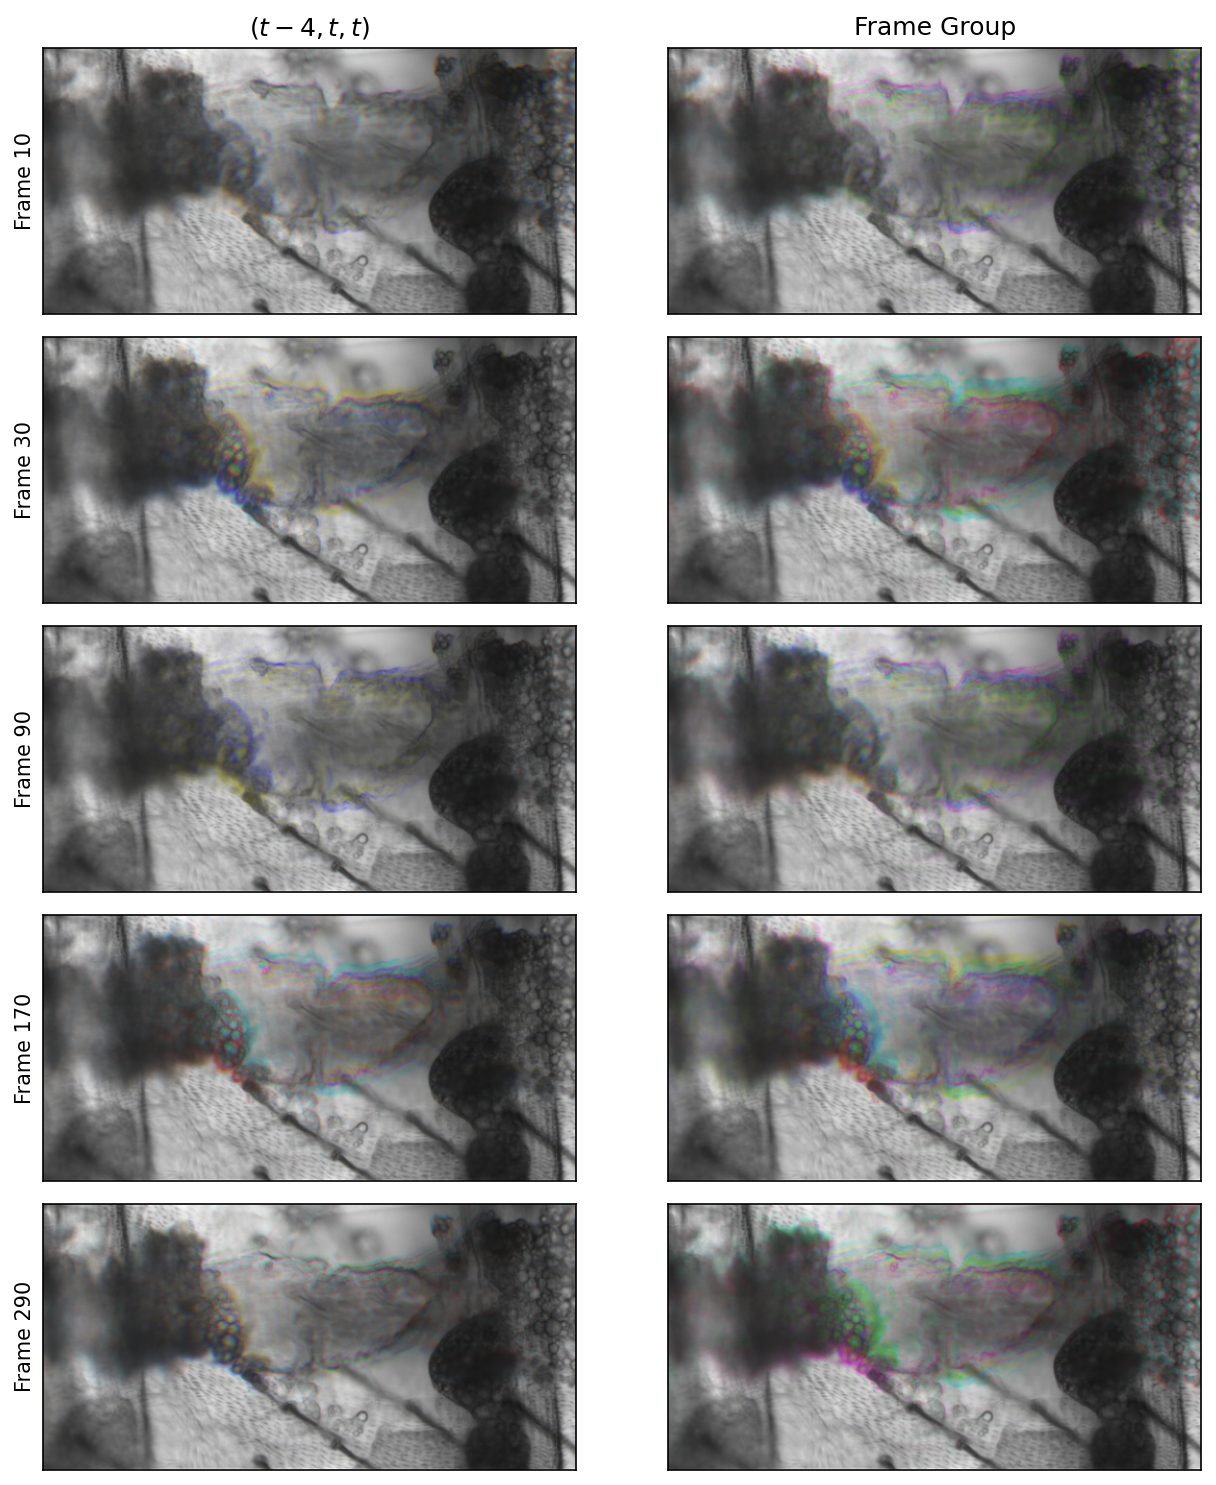

In [45]:
frames = [10, 30, 90, 170, 290]
n_frames = len(frames)

fig, axs = plt.subplots(n_frames, 2, figsize=(9, n_frames*2), dpi=150)

for i in range(n_frames):    
    cap.set(cv2.CAP_PROP_POS_FRAMES, frames[i]-4)
    _, f1 = cap.read()
    cap.set(cv2.CAP_PROP_POS_FRAMES, frames[i])
    _, f2 = cap.read()
    cap.set(cv2.CAP_PROP_POS_FRAMES, frames[i]+4)
    _, f3 = cap.read()
    
    f = np.zeros_like(f1)
    f[:, :, 0] = f1[:, :, 0]
    f[:, :, 1] = f2[:, :, 0]
    f[:, :, 2] = f3[:, :, 0]
    
    ax = axs[i, 0] 
    ax.imshow(f)
    ax.set_ylabel(f'Frame {frames[i]}')
    ax.set_xticks([])
    ax.set_yticks([])

    
for i in range(n_frames):    
    pf, nf = frame_neighbors[frames[i]]
    
    print(pf, frames[i], nf)
    cap.set(cv2.CAP_PROP_POS_FRAMES, pf)
    _, f1 = cap.read()
    cap.set(cv2.CAP_PROP_POS_FRAMES, frames[i])
    _, f2 = cap.read()
    cap.set(cv2.CAP_PROP_POS_FRAMES, nf)
    _, f3 = cap.read()
    
    f = np.zeros_like(f1)
    f[:, :, 0] = f1[:, :, 0]
    f[:, :, 1] = f2[:, :, 0]
    f[:, :, 2] = f3[:, :, 0]
    
    ax = axs[i, 1] 
    ax.imshow(f)
    ax.set_xticks([])
    ax.set_yticks([])
    
axs[0, 0].set_title('$(t-4, t, t)$')
axs[0, 1].set_title('Frame Group')
plt.tight_layout()
plt.show()

# Video Lengths

In [ ]:
import 

# Test Frame Access

Sometimes when I have used cv2.VideoCapture.set() to get a specific frame, cap.read() does not return the correct frame. 

In [9]:
import numpy as np
import matplotlib.pyplot as plt

import cv2
import time

### Check ITER vs SET agreement

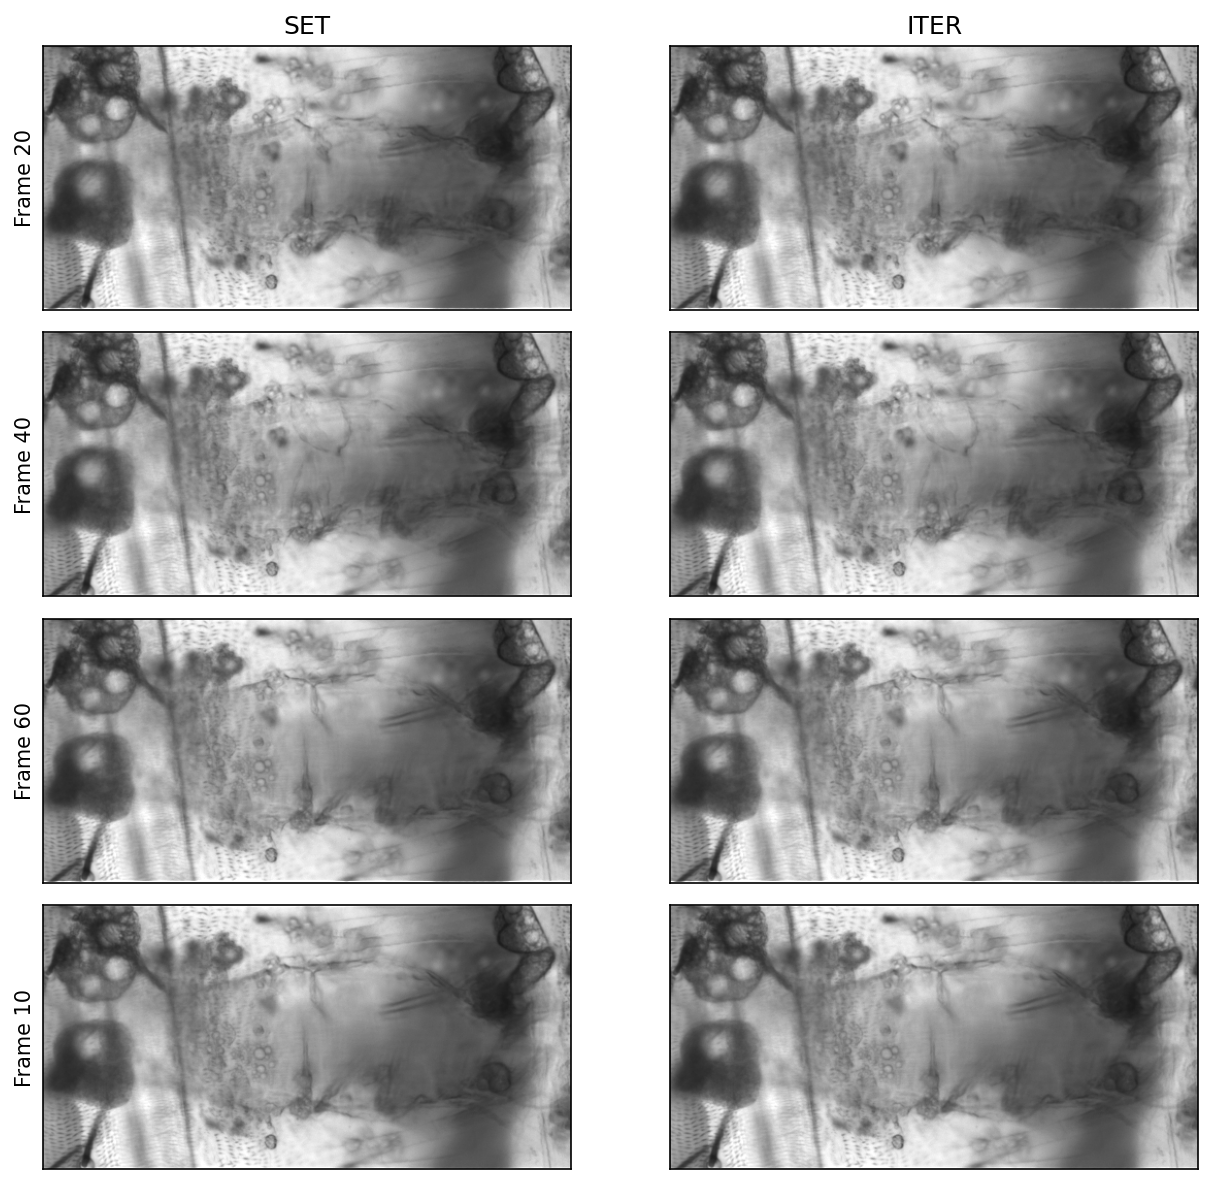

In [30]:
path = '../../../../../../project/Drosophila_MelkaniLab/YASH/Videos/Control/Control_1wf_02_C11440_30s2.avi'

targets = [20, 40, 60, 10]
n_targets = len(targets)

fig, axs = plt.subplots(n_targets, 2, figsize=(9, n_targets*2), dpi=150)

#SET
cap = cv2.VideoCapture(path)
for i in range(n_targets):
    cap.set(cv2.CAP_PROP_POS_FRAMES, targets[i])
    _, frame = cap.read()
    
    ax = axs[i, 0] 
    ax.imshow(frame)
    ax.set_ylabel(f'Frame {targets[i]}')
    ax.set_xticks([])
    ax.set_yticks([])

#ITER
cap = cv2.VideoCapture(path)
for i in range(n_targets):
    
    curr = int(cap.get(cv2.CAP_PROP_POS_FRAMES))
    if targets[i] < curr:
        cap = cv2.VideoCapture(path)
    
    curr = int(cap.get(cv2.CAP_PROP_POS_FRAMES))
    for _ in range(curr, targets[i]):
        cap.read()
    
    _, frame = cap.read()
    
    ax = axs[i, 1] 
    ax.imshow(frame)
    ax.set_xticks([])
    ax.set_yticks([])

axs[0, 0].set_title('SET')
axs[0, 1].set_title('ITER')

    
plt.tight_layout()

### Test ITER vs SET speed

In [16]:
def get_frames_iter(path, target_frames):
    
    cap = cv2.VideoCapture(path)
    for target in target_frames:
        
        curr = int(cap.get(cv2.CAP_PROP_POS_FRAMES))
        if target < curr:
            cap = cv2.VideoCapture(path)
            
        curr = int(cap.get(cv2.CAP_PROP_POS_FRAMES))
        for i in range(curr, target):
            cap.read()
        
        _, frame = cap.read()
    
def get_frames_set(path, target_frames):
    
    cap = cv2.VideoCapture(path)
    for target in target_frames:
        
        cap.set(cv2.CAP_PROP_POS_FRAMES, target)
        _, frame = cap.read()


In [17]:
path = '../../../../../../project/Drosophila_MelkaniLab/YASH/Videos/Control/Control_1wf_02_C11440_30s2.avi'

np.random.seed(0)
target_frames = np.random.randint(0, 500, size=(1000))

t0 = time.time()
get_frames_iter(path, target_frames)
print('ITER:', time.time() - t0)
    
t0 = time.time()
get_frames_set(path, target_frames)
print('SET:', time.time() - t0)

ITER: 43.4478120803833
SET: 1.9595446586608887


# Pad/Crop Image

In [18]:
import numpy as np
import matplotlib.pyplot as plt

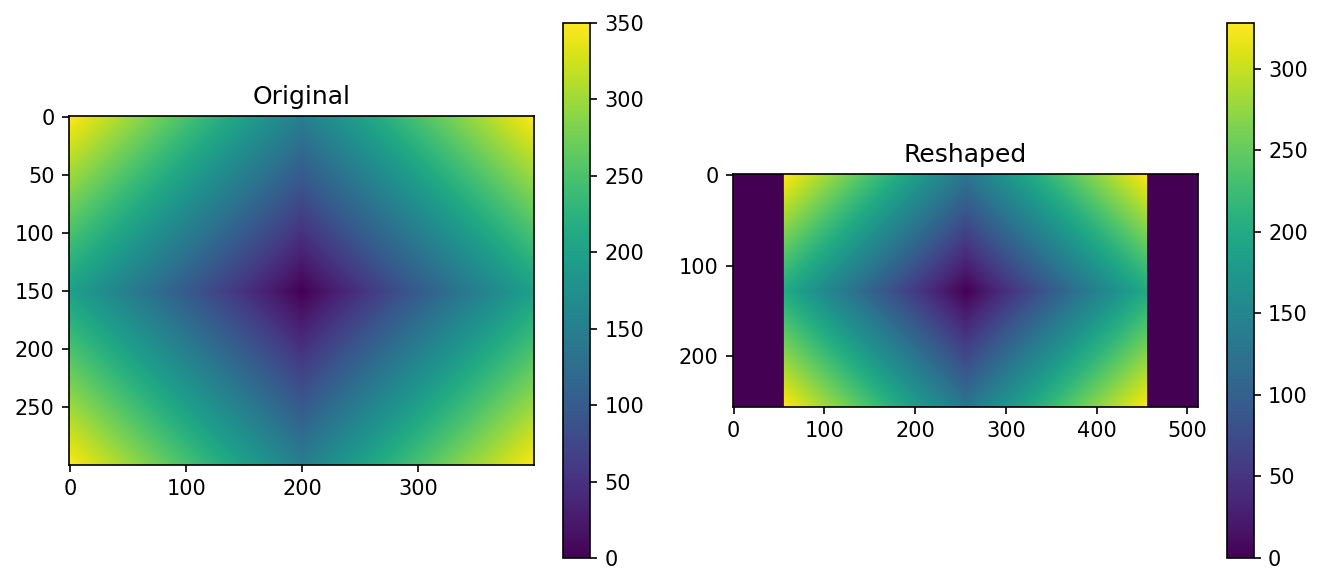

In [72]:
h, w = (300, 400)
arr = np.zeros((1, h, w))
arr = arr + np.abs((np.arange(h)-h//2)[None, :, None]) + np.abs((np.arange(w)-w//2)[None, None, :])
# arr = arr + np.arange(h)[None, :, None] + np.arange(w)[None, None, :]

H, W = (256, 512) #hardcoded
c, h, w = arr.shape

padded_arr = np.zeros((c, H, W), dtype=arr.dtype)

min_h = min(H, h)
min_w = min(W, w)
dh = (H-h)//2
dw = (W-w)//2

padded_arr[:, max(dh, 0):max(dh, 0) + min_h, max(dw, 0):max(dw, 0) + min_w] = arr[:, max(-dh, 0):max(-dh, 0) + min_h, max(-dw, 0):max(-dw, 0) + min_w]


fig, ax = plt.subplots(1, 2, figsize=(9,4), dpi=150)

subplt = ax[0].imshow(arr[0])
plt.colorbar(subplt,ax=ax[0])
ax[0].set_title('Original')

subplt = ax[1].imshow(padded_arr[0])
plt.colorbar(subplt,ax=ax[1])
ax[1].set_title('Reshaped')

plt.tight_layout()
plt.show()

# Frame Grouping w/o labels

The heart generally spends more time in diastolic than systolic. This means our training dataset has an imbalance between 'relaxed' frames and 'contracted' frames. Normally I use the hand drawn segmentation masks to calculate diameter for each frame and then bootstrap frames in systolic so that all diameters are equally represented. For Masked AutoEncoder pretraining, I do not have these labels. I will look at Mean Squared Error between the first frame and the remaining frames instead.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

from tqdm import tqdm

import torch
from torchvision import tv_tensors
from torchvision.io import read_image

### Testing on Labelled Data

100%|██████████| 500/500 [00:23<00:00, 21.25it/s]


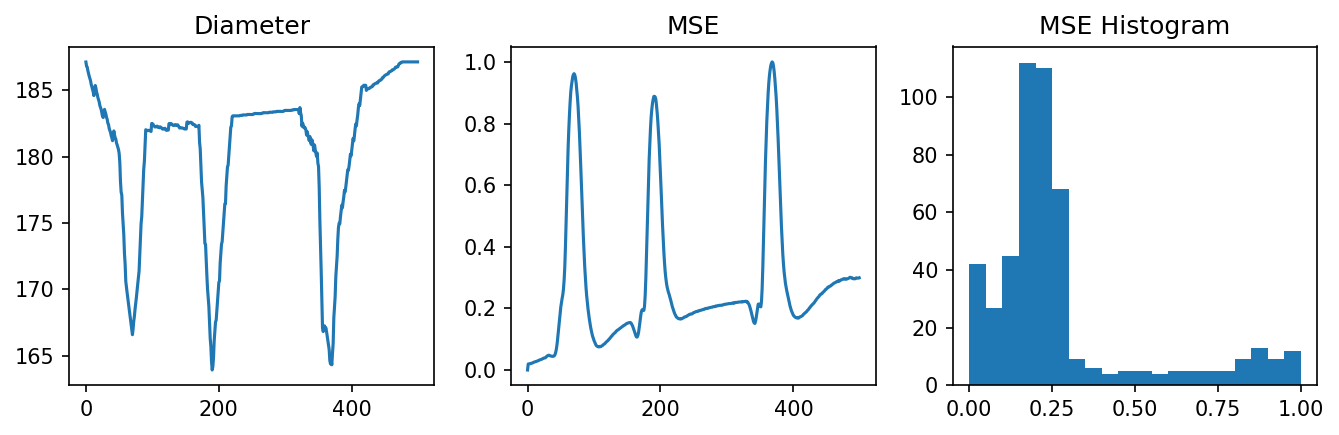

In [5]:
base_path = '../../../../../../../data/project/Drosophila_MelkaniLab/SHARED_VIDEOS/machine_learning/training/task_500_kd_05_3wf/'
# base_path = '../../../../../../../data/project/Drosophila_MelkaniLab/SHARED_VIDEOS/machine_learning/training/'

img_ext = '.png'
mask_ext = '.png'

diffs = []
diams = []

img_0 = read_image(os.path.join(base_path, 'default', 'frame_000000' + img_ext)) / 255

for i in tqdm(range(0, 500)):
    
    img_path = os.path.join(base_path, 'default', f'frame_{i:06d}' + img_ext)
    img = read_image(img_path) / 255

    diffs.append(((img_0 - img)**2).mean())

    mask_path = os.path.join(base_path, 'defaultannot', f'frame_{i:06d}' + mask_ext)
    mask = read_image(mask_path)[0, :, :] > 0
    
    col_sum = mask.sum(axis=0)
    diams.append(col_sum.sum() / (torch.count_nonzero(col_sum > 0)))
    
diffs = torch.tensor(diffs)
diffs = diffs / diffs.max() # already know that diffs.min() = 0
    
fig, ax = plt.subplots(1, 3, figsize=(9,3), dpi=150)

ax[0].plot(diams)
ax[0].set_title('Diameter')
ax[1].plot(diffs)
ax[1].set_title('MSE')
ax[2].hist(diffs, bins=20) 
ax[2].set_title('MSE Histogram')

plt.tight_layout()
plt.show()

Text(0.5, 0, 'Group #')

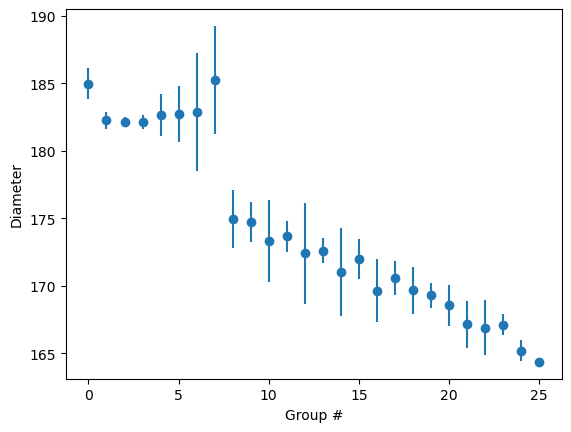

In [8]:
n_bins = 25

diam_frames = {}

for i in range(len(diffs)):
    
    diam_id = int(diffs[i] * n_bins)
    
    if diam_id not in diam_frames:
        diam_frames[diam_id] = []
    diam_frames[diam_id].append(diams[i])

x = []
means = []
stds = []

for diam_id in diam_frames:
    
    temp = torch.tensor(diam_frames[diam_id])
    
    x.append(diam_id)
    if len(temp) == 1:
        means.append(temp[0])
        stds.append(0)
    else:
        means.append(temp.mean())
        stds.append(temp.std())

plt.errorbar(x, means, yerr=stds, fmt='o')
plt.ylabel('Diameter')
plt.xlabel('Group #')

### Unlabelled Data

True 785402756


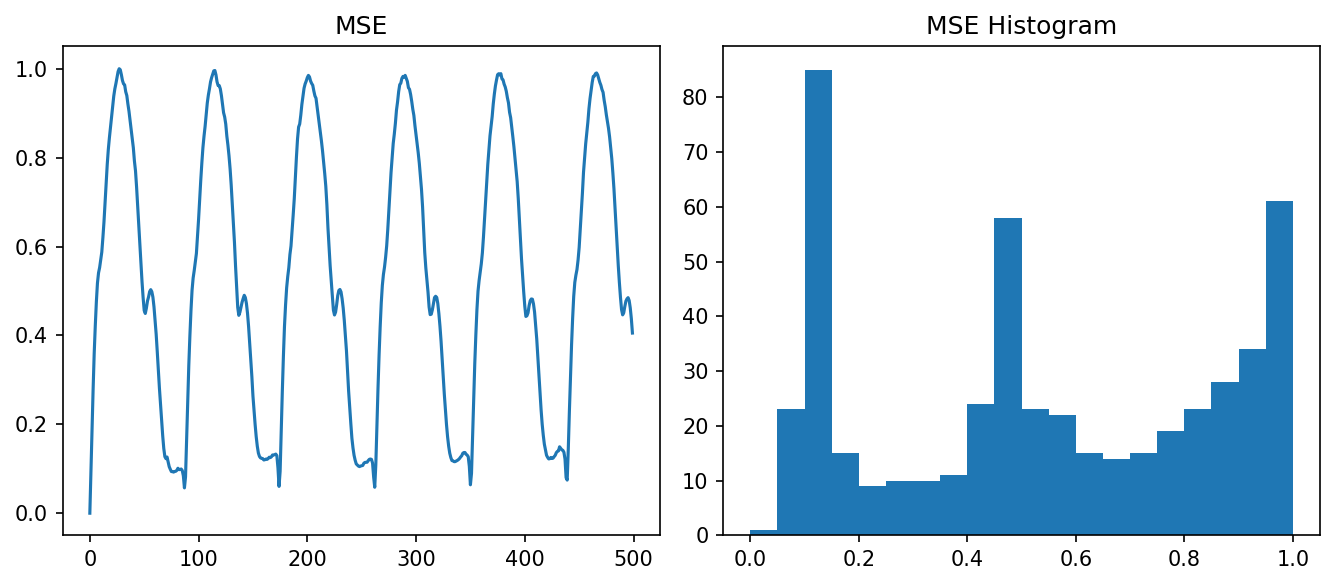

In [7]:
path = '../../../../../../project/Drosophila_MelkaniLab/YASH/Videos/Control/Control_1wf_02_C11440_30s2.avi'
cap = cv2.VideoCapture(path)

print(cap.isOpened(), os.path.getsize(path))

ret, img_0 = cap.read()
img_0 = img_0[:, :, 0]

mses = [0]

for i in range(1, 500):
    
    ret, img = cap.read()
    
    mses.append(np.mean((img[:, :, 0] - img_0)**2))
    
mses = np.array(mses) 
mses *= (1 / mses.max()) # we know mses.min() = 0

fig, ax = plt.subplots(1, 2, figsize=(9,4), dpi=150)

ax[0].plot(mses)
ax[0].set_title('MSE')
ax[1].hist(mses, bins=20) 
ax[1].set_title('MSE Histogram')

plt.tight_layout()
plt.show()

In [24]:
path = '../../../../../../project/Drosophila_MelkaniLab/YASH/Videos/Control/Control_1wf_02_C11440_30s2.avi'
cap = cv2.VideoCapture(path)

for i in tqdm(range(500)):
    
    ret, img = cap.read()

100%|██████████| 500/500 [00:00<00:00, 1660.09it/s]


# Image Augmentations

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

import torch
from torchvision import tv_tensors
from torchvision.io import read_image
from torchvision.transforms import v2

/home/ymelkani/.conda/envs/heart-analysis/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


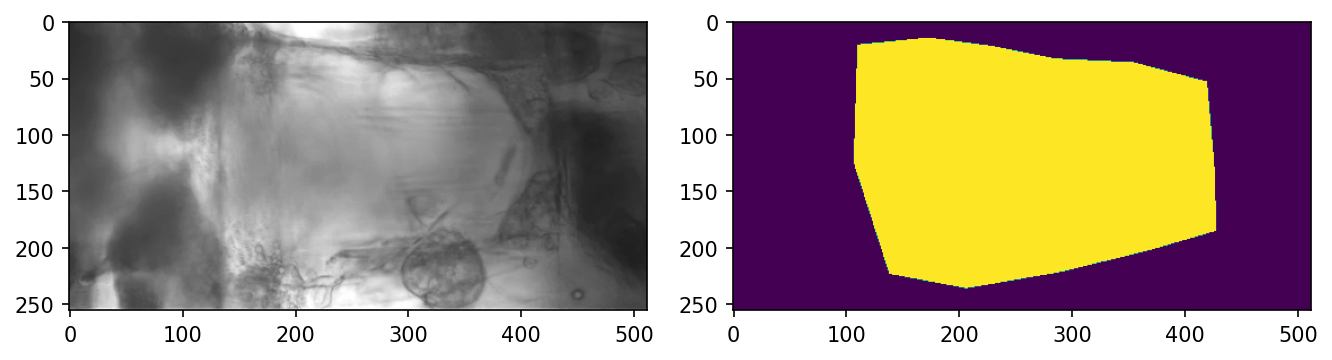

In [13]:
base_path = '../../../../../../../../data/project/Drosophila_MelkaniLab/SHARED_VIDEOS/machine_learning/training/task_500_kd_05_3wf/'

frame = 'frame_000100.png'

img_path = os.path.join(base_path, 'default', frame)
mask_path = os.path.join(base_path, 'defaultannot', frame)

# read_image works with .png (test with task_w1118_1wm_01_c11440_30s-control14.avi-2021_12_26_08_56_12-camvid 1.0)
img = read_image(img_path)
mask = read_image(mask_path)

# preprocess
img = img / 255

mask = mask[0:1, :, :]
mask = (mask != 0).to(dtype=torch.float32)

mask = tv_tensors.Mask(mask)

fig, ax = plt.subplots(1, 2, figsize=(9,4), dpi=150)

ax[0].imshow(torch.permute(img, (1, 2, 0))) # (C, H, W) -> (H, W, C)
ax[1].imshow(torch.permute(mask, (1, 2, 0))) # (C, H, W) -> (H, W, C)

plt.tight_layout()

In [14]:
transforms = v2.Compose([v2.ColorJitter(brightness = 0.3, contrast = 0.3),
                         v2.RandomAffine(degrees=(-20, 20), translate=(0.1, 0.1), scale=(0.8, 1.2), shear=(-0.1, 0.1, -0.1, 0.1)),
                         v2.RandomPerspective(distortion_scale=0.3, p=0.5),
                         v2.RandomHorizontalFlip(p=0.5),
                         v2.RandomVerticalFlip(p=0.5)
                        ])

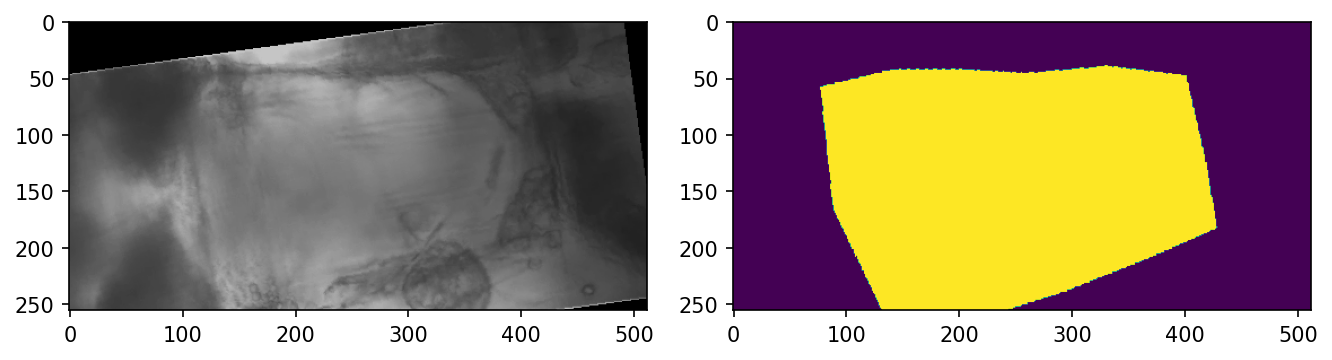

In [15]:
out_img, out_mask = transforms(img, mask)

fig, ax = plt.subplots(1, 2, figsize=(9,4), dpi=150)
ax[0].imshow(torch.permute(out_img, (1, 2, 0)))
ax[1].imshow(torch.permute(out_mask, (1, 2, 0)))
plt.tight_layout()

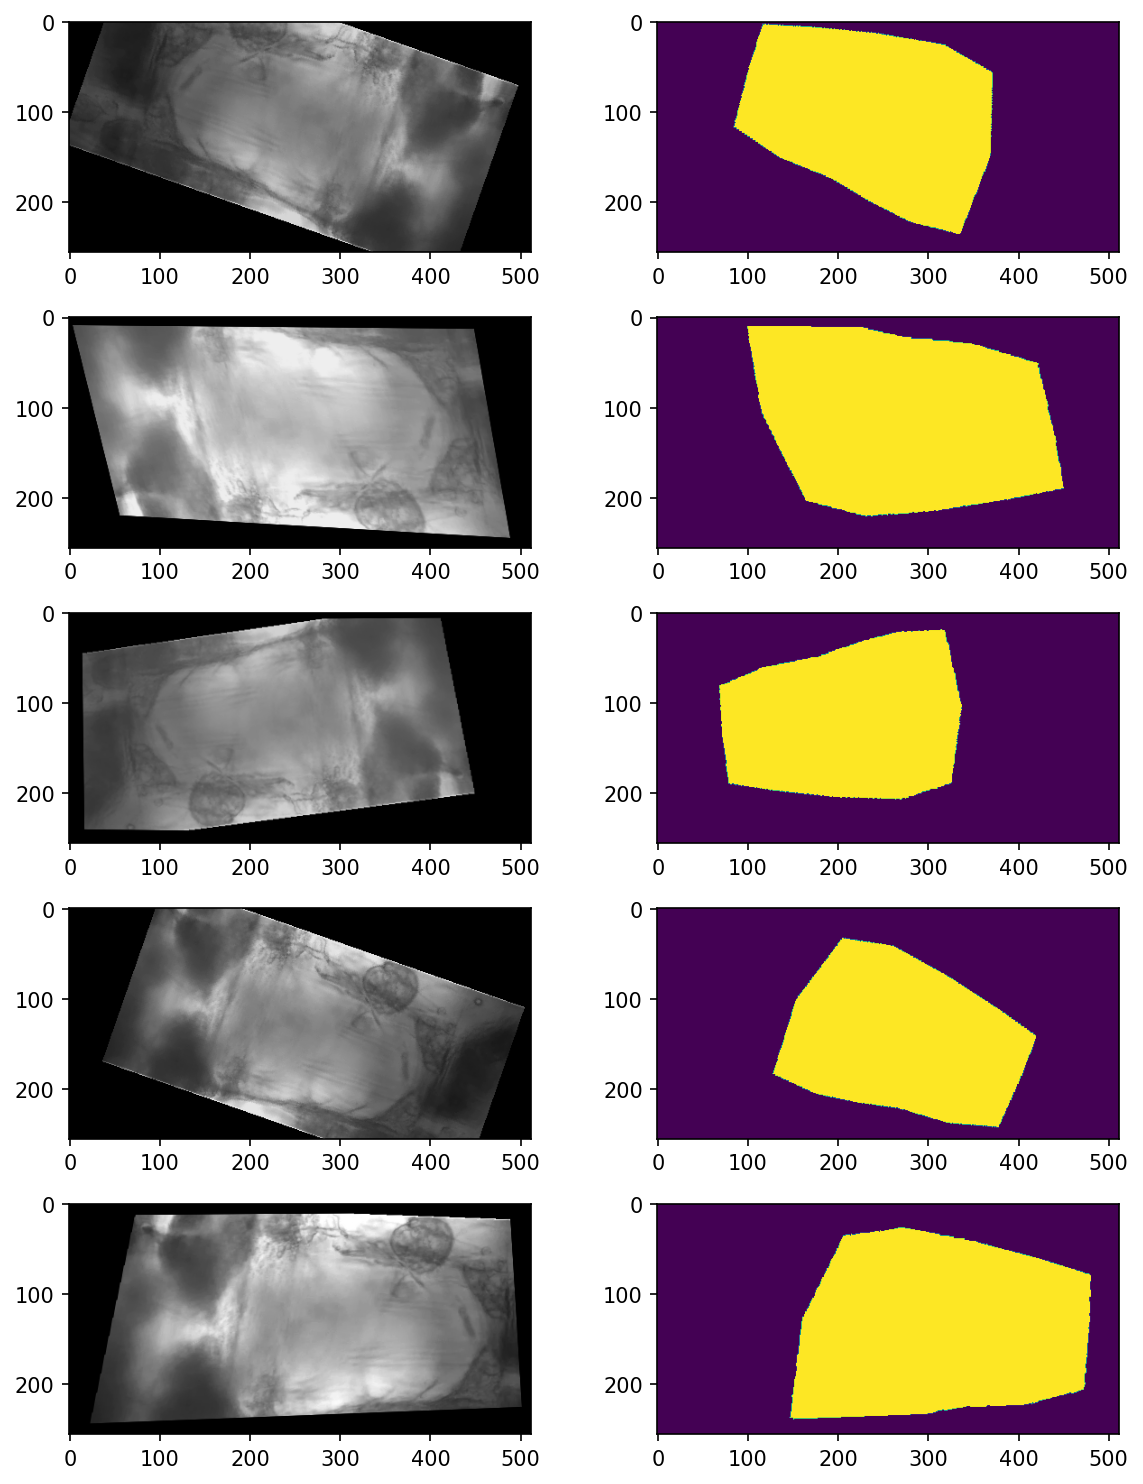

In [16]:
n = 5

fig, ax = plt.subplots(n, 2, figsize=(8, 2*n), dpi=150)

for i in range(n):
    out_img, out_mask = transforms(img, mask)

    ax[i, 0].imshow(torch.permute(out_img, (1, 2, 0)))
    ax[i, 1].imshow(torch.permute(out_mask, (1, 2, 0)))
    
    
plt.tight_layout()